In [1]:
import mlflow
import mlflow.sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from mlflow.models.signature import infer_signature

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)


LogisticRegression(max_iter=200)

2. 🧪 Utiliser mlflow.start_run()
Bonne pratique : chaque expérience doit être encapsulée

In [3]:
import mlflow
with mlflow.start_run(run_name="logreg_iris"):
    model = LogisticRegression(max_iter=200)
    model.fit(X_train, y_train)


 3. 📊 Logger les paramètres, métriques, artéfacts et modèles

In [4]:
from sklearn.metrics import accuracy_score
import mlflow.sklearn

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

mlflow.log_param("max_iter", 200)
mlflow.log_metric("accuracy", acc)
mlflow.sklearn.log_model(model, "model")


2025/05/06 10:23:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


3. 1-**Logger un graphe** :

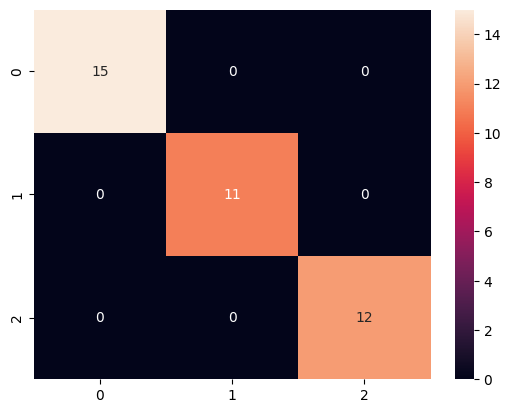

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.savefig("plots/cm.png")
mlflow.log_artifact("plots/cm.png")


4. 🔁 Reproductibilité
   

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = LogisticRegression(max_iter=200, random_state=42)


 * **fermer le run actif**
Dans une cellule juste avant la boucle :

In [7]:
import mlflow

# Ferme un run précédent s'il est encore ouvert
if mlflow.active_run() is not None:
    mlflow.end_run()


5. 🚀 Comparaison de modèles

In [8]:
models = {
    "logreg": LogisticRegression(max_iter=200, random_state=42),
    "svc": SVC(kernel="linear", probability=True, random_state=42)
}

for name, clf in models.items():
    with mlflow.start_run(run_name=name):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        mlflow.log_param("model", name)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, "model")


2025/05/06 10:23:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/06 10:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


* `input_example` : un exemple d’entrée (ex. une ligne de test)

* `signature` : le schéma d’entrée/sortie du modèle (dimensions et types)

In [9]:
from mlflow.models.signature import infer_signature

for name, clf in models.items():
    with mlflow.start_run(run_name=name):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        mlflow.log_param("model", name)
        mlflow.log_metric("accuracy", acc)

        # 👇 Ajouter input_example + signature
        input_example = X_test[:1]
        signature = infer_signature(X_test, y_pred)

        mlflow.sklearn.log_model(
            clf,
            "model",
            signature=signature,
            input_example=input_example
        )

6. 🧰 Logger la signature + exemple pour servir plus tard

In [10]:
from mlflow.models.signature import infer_signature
signature = infer_signature(X_test, y_pred)

mlflow.sklearn.log_model(
    model,
    "model",
    signature=signature,
    input_example=X_test[:1]
)


2025/05/06 10:23:46 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      6.1,
      2.8,
      4.7,
      1.2
    ]
  ]
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example can be generated from model input example using `mlflow.models.convert_input_example_to_serving_input` function.
Got error: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


Cela te permet de :

* Recharger automatiquement le modèle dans mlflow.pyfunc.load_model()

* Le servir plus tard via API avec typage clair



7. 📦 Déploiement local simple (serveur REST)